In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

In [2]:
df_dostavka = pd.read_excel(r'd:\Работа ВВЮ\DataScience\Final project\Dostavka.xlsx')

In [3]:
df__sort=df_dostavka.sort_values('Время открытия', ascending=[True])

In [4]:
df_daily=df__sort.groupby(pd.Grouper(key='Время открытия', freq='1D')).sum().copy()

[Text(0.5, 0, 'Дата')]

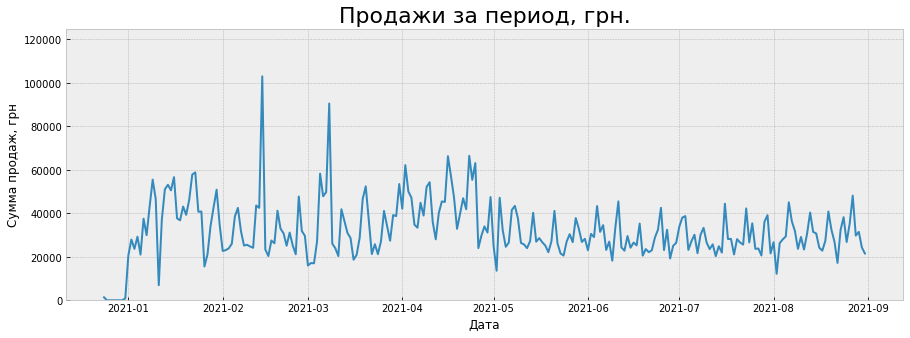

In [5]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(df_daily['Сумма со скидкой, грн.'])

ax.set_title('Продажи за период, грн.', fontdict={'size':22})
ax.set(ylabel='Сумма продаж, грн', ylim=(0, 125000))
ax.set(xlabel='Дата')

In [7]:
df_daily.reset_index(inplace=True)
df_daily['Время открытия'] = pd.to_datetime(df_daily['Время открытия']) 

In [72]:
data=df_daily[['Время открытия', 'Сумма со скидкой, грн.']].copy()
data=data.rename(columns={'Время открытия': 'Time', 'Сумма со скидкой, грн.': 'Sales'})
data=data.set_index('Time')
data

,Sales
Time,
2020-12-24,1375.00
2020-12-25,0.00
2020-12-26,0.00
2020-12-27,0.00
2020-12-28,0.00
...,...
2021-08-27,48133.83
2021-08-28,29758.50
2021-08-29,31483.50


In [23]:
data_0 = data[data.index >= '2021-01-01']

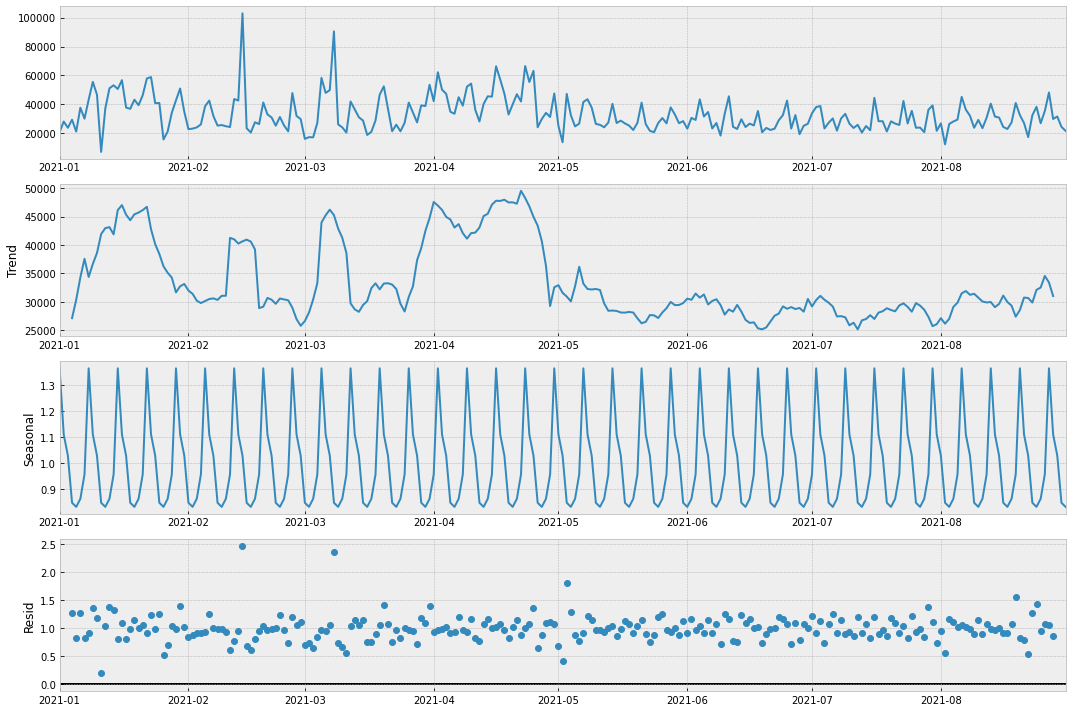

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (15,10)
result = seasonal_decompose(data_0, model='multiplicative')
result.plot()
plt.show()

### XGBoost

In [25]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [33]:
split_date = '2021-07-01'
train, test = split_data(data_0, split_date)

In [34]:
train.shape, test.shape

((182, 1), (61, 1))

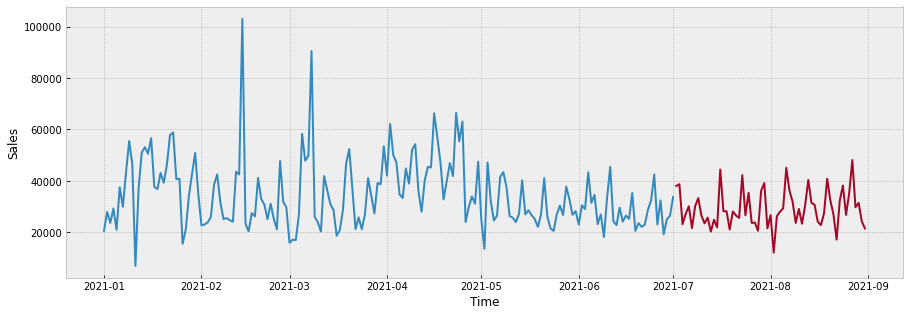

In [35]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [37]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','dayofyear','dayofmonth','weekofyear']]
    return X

In [38]:
X_train, y_train = create_features(train), train['Sales']
X_test, y_test   = create_features(test), test['Sales']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

<ipython-input-37-c0b10f32e311>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


((182, 6), (182,), (61, 6), (61,))

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

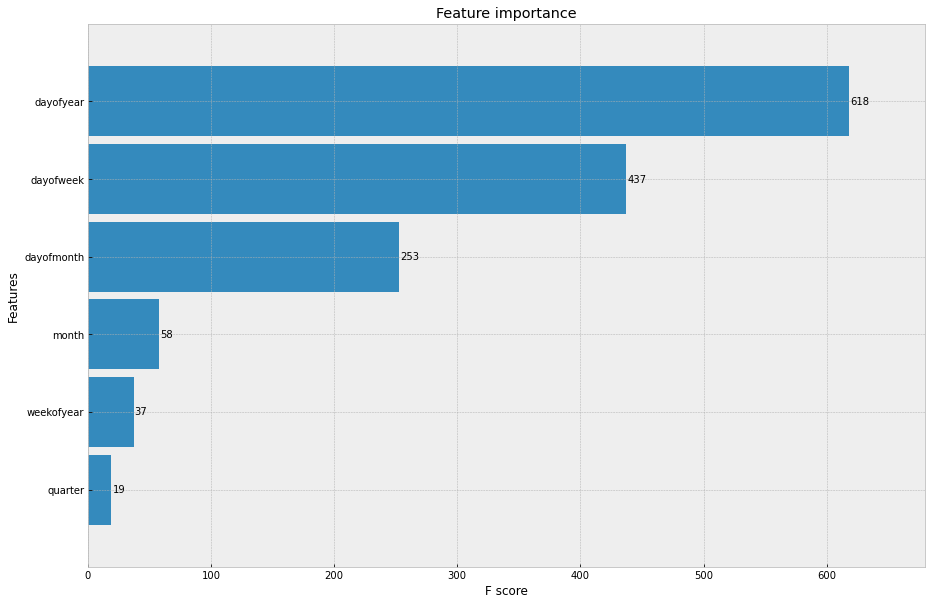

In [41]:
xgb.plot_importance(reg, height=0.9)

In [42]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.plot(data.index,data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

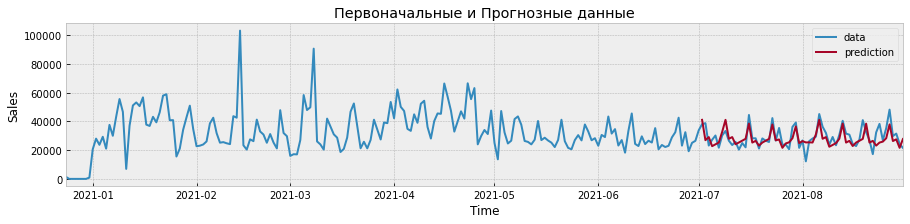

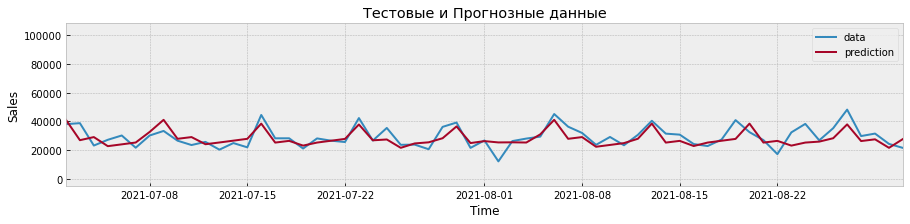

In [43]:
X_test_pred = reg.predict(X_test)
    
plot_performance(data, data.index[0].date(), data.index[-1].date(),
                 'Первоначальные и Прогнозные данные')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Тестовые и Прогнозные данные')

#plot_performance(y_test, '01-08-2021', '01-09-2021', 'Август 2021')

plt.legend()

plt.show()

In [44]:
mean_squared_error(y_true=y_test, y_pred=X_test_pred)

30193824.880937077

In [45]:
mean_absolute_error(y_true=y_test, y_pred=X_test_pred)

4382.265698002049

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
print('MAPE =', mean_absolute_percentage_error(y_test,X_test_pred).round(4))

MAPE = 15.7881


### ARIMA

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

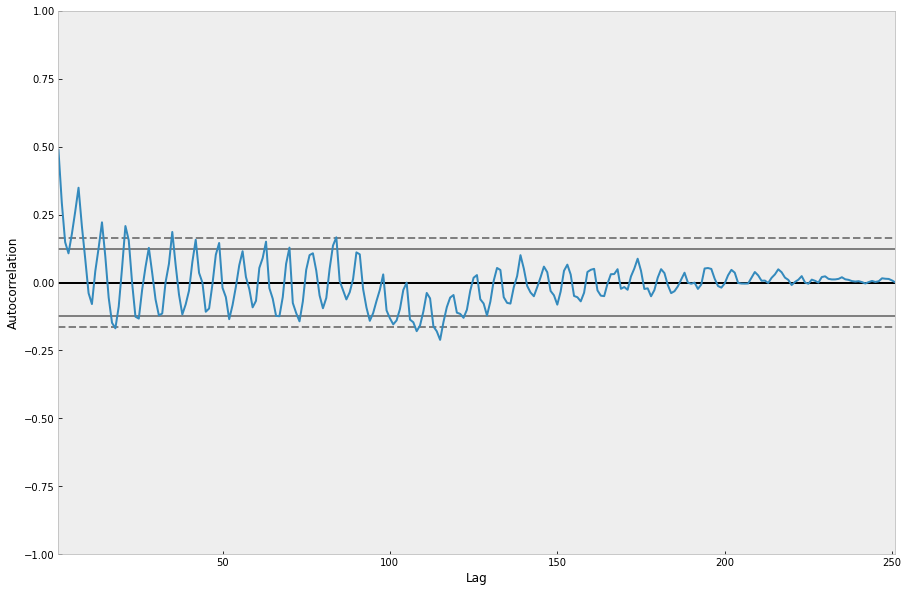

In [48]:
pd.plotting.autocorrelation_plot(data)

In [49]:
from statsmodels.tsa.arima_model import ARIMA

In [50]:
model = ARIMA(data, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D wil

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  250
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2681.030
Method:                       css-mle   S.D. of innovations          10963.606
Date:                Sun, 24 Oct 2021   AIC                           5386.061
Time:                        12:02:36   BIC                           5428.318
Sample:                    12-25-2020   HQIC                          5403.068
                         - 08-31-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            124.6377    220.738      0.565      0.572    -308.000     557.276
ar.L1.D.Sales     -0.5966      0.063     -9.429      0.000      -0.721      -0.473
ar.L2.D.Sales     -0.4785      0.074

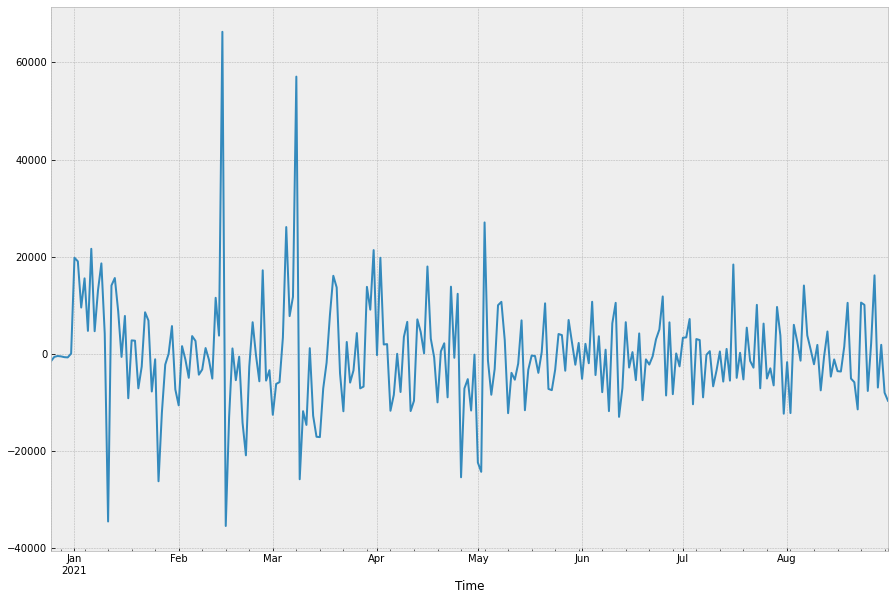

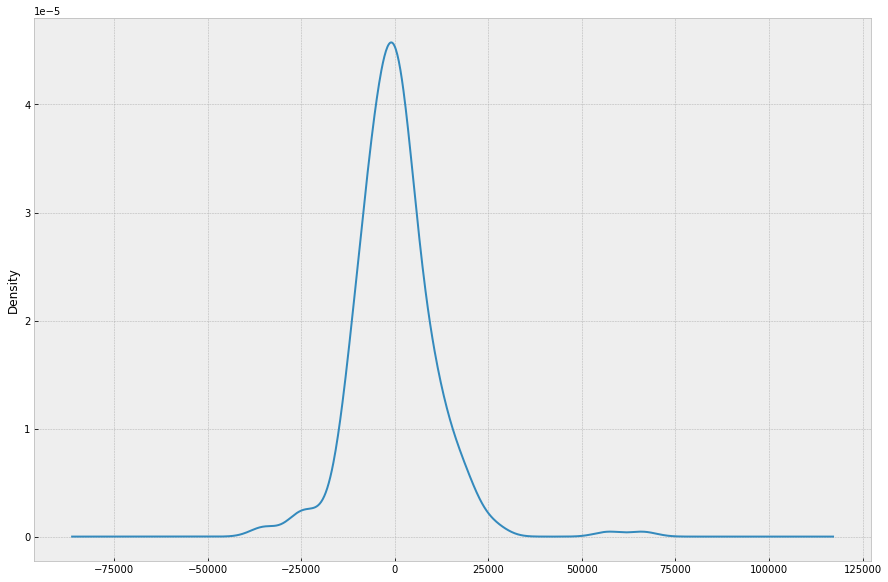

count      250.000000
mean       -32.825110
std      10986.767218
min     -35398.873331
25%      -5814.769333
50%       -544.447615
75%       4458.598084
max      66280.132546
dtype: float64


In [51]:
residuals = model_fit.resid
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=24103.873946, expected=26445.500000
predicted=23985.021158, expected=33760.700000
predicted=29804.171891, expected=38023.850000
predicted=39277.524549, expected=38727.620000
predicted=39284.298528, expected=23168.770000
predicted=28076.562837, expected=27160.070000
predicted=27298.975930, expected=30153.000000
predicted=31122.196360, expected=21660.880000
predicted=21861.596451, expected=30147.010000
predicted=25352.302125, expected=33315.370000
predicted=30740.275710, expected=26542.670000
predicted=29375.198121, expected=23524.380000
predicted=23039.054044, expected=25721.620000
predicted=24441.613208, expected=20308.340000
predicted=22270.262810, expected=24887.950000
predicted=22541.732219, expected=21932.910000
predicted=19741.204830, expected=44413.490000
predicted=42351.555950, expected=28193.500000
predicted=32780.907793, expected=28207.780000
predicted=28629.679991, expected=21093.970000
predicted=23099.331268, expected=28122.650000
predicted=28617.226315, expected=2

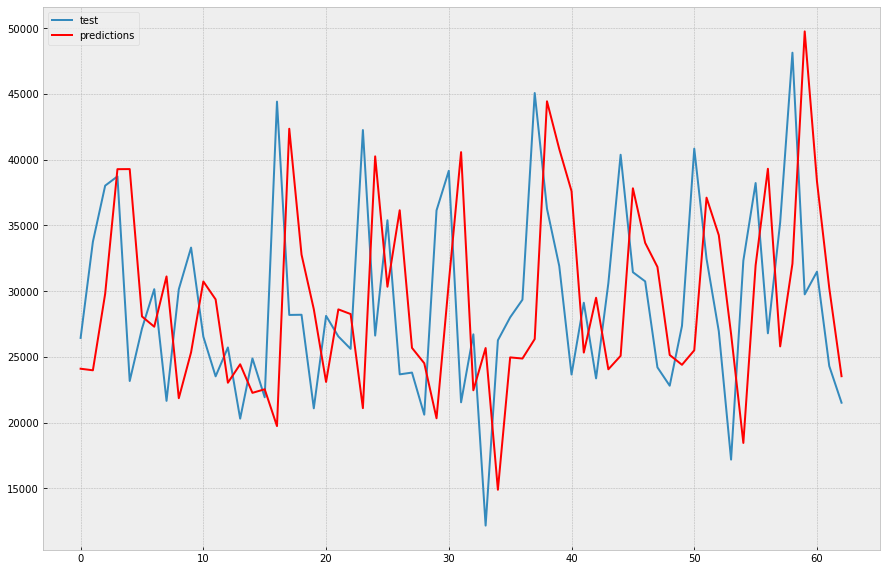

In [56]:
X = data.Sales
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
test1 =[x for x in test]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,2,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test1, label = 'test')
plt.plot(predictions, color='red', label = 'predictions')
plt.legend()
plt.show()

### SARIMA

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [73]:
data

,Sales
Time,
2020-12-24,1375.00
2020-12-25,0.00
2020-12-26,0.00
2020-12-27,0.00
2020-12-28,0.00
...,...
2021-08-27,48133.83
2021-08-28,29758.50
2021-08-29,31483.50


In [74]:
data = data
my_order = (2, 1, 1)
my_seasonal_order = (1, 1, 1, 7)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, enforced_stationarity = False, enforce_inveribility = False)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\VladV\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  251
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2618.267
Date:                           Sun, 24 Oct 2021   AIC                           5248.534
Time:                                   12:30:16   BIC                           5269.493
Sample:                               12-24-2020   HQIC                          5256.976
                                    - 08-31-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1533      0.169      0.908      0.364      -0.178       0.484
ar.L2          0.0128      0.146      0.088

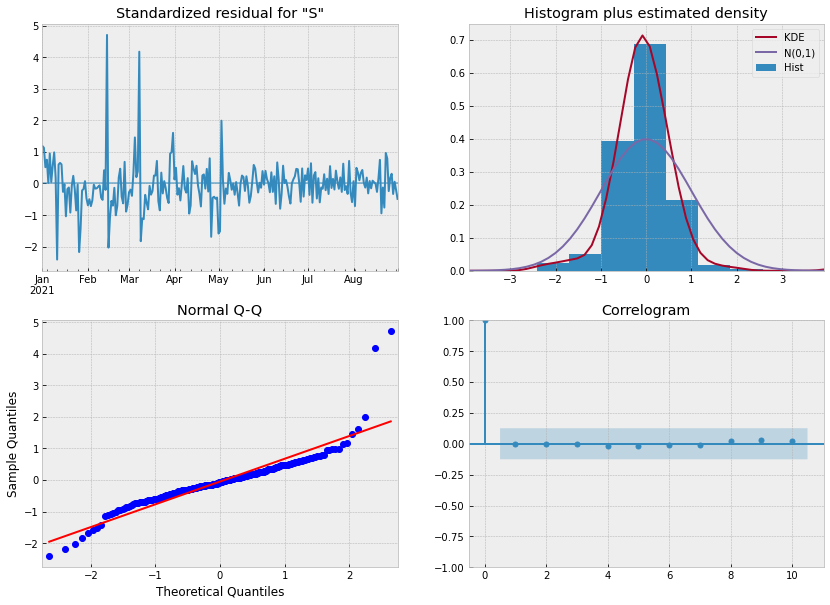

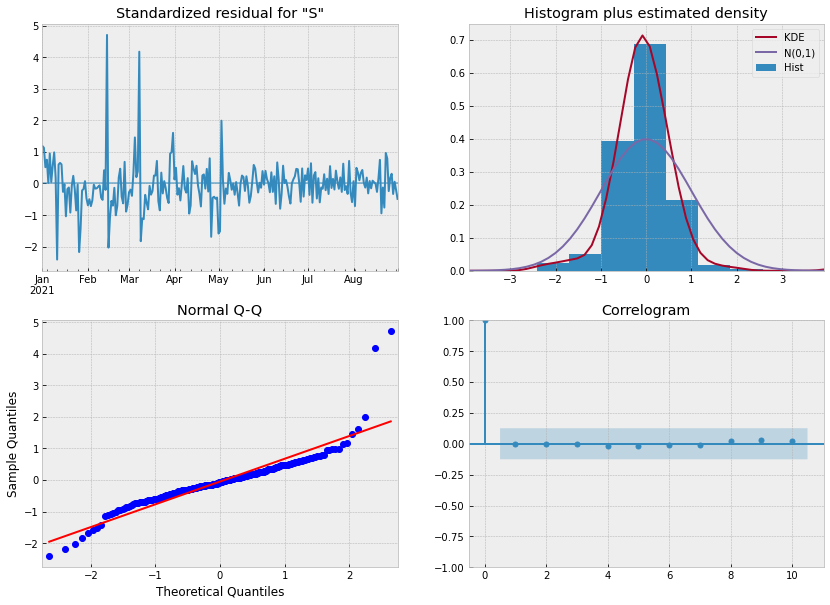

In [75]:
model_fit.plot_diagnostics(figsize=(14,10))

In [76]:
forecast_values = model_fit.get_forecast(steps=30)
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()

Sales,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-01,25199.024973,14498.040731,-3216.612706,53614.662652
2021-09-02,31328.756381,15508.192854,933.256923,61724.255839
2021-09-03,41313.585551,16096.549769,9764.927728,72862.243374
2021-09-04,30095.070509,16589.564403,-2419.878241,62610.019259
2021-09-05,28564.768843,17054.120921,-4860.693951,61990.231637
2021-09-06,24766.125616,17503.390637,-9539.889640,59072.140873
2021-09-07,26768.389367,17940.801347,-8394.935127,61931.713861
2021-09-08,25999.032331,18743.079438,-10736.728327,62734.792989
2021-09-09,31628.162505,19276.138196,-6152.374120,69408.699130
2021-09-10,41552.986335,19767.344409,2809.703224,80296.269445


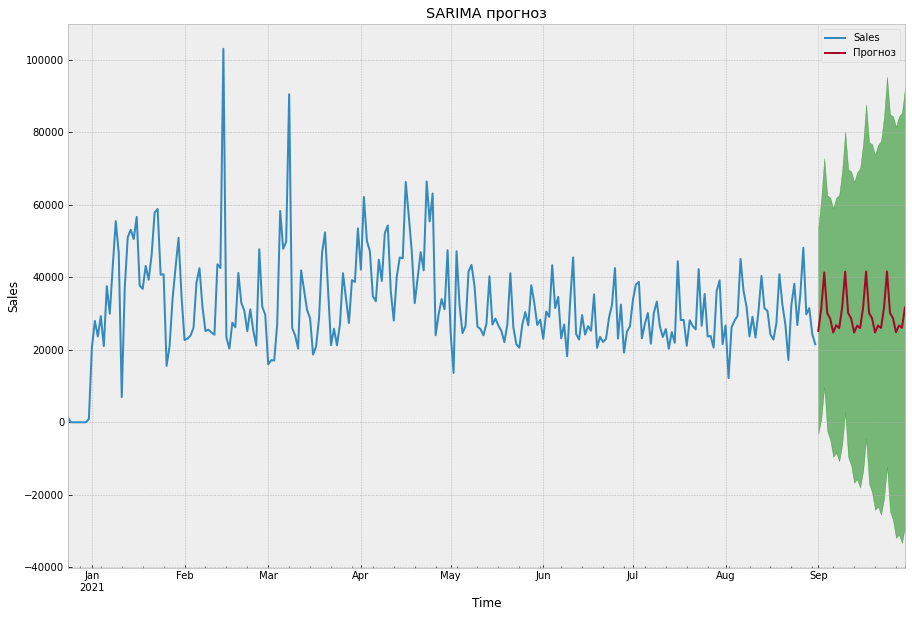

In [77]:

ax = data.plot()

forecast_values.predicted_mean.plot(ax=ax, label = 'Прогноз')

ax.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color = 'g', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('Sales')
ax.set_title('SARIMA прогноз')

plt.legend()